Student Name: Ananya Krithika Thyagarajan

Student ID: 23187123

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
torch.cuda.current_device()

0

In [3]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

### model.train():

The function model.train() is used to put the model in training mode. This is significant because certain operations—like dropout layers and batch normalisation layers—behave differently in training than in evaluation. These layers will carry out training-related tasks when in training mode (e.g., randomly zeroing off nodes in dropout).

### X.to(device), y.to(device):

The tensors X (inputs/features) and Y (targets/labels) are moved by this code to the computing device (such as a CPU or GPU) for the purpose of doing computations. It's a means of guaranteeing that the data and the model are on the same device, which is required for computing.


### model(X):

To get predictions, this line runs the input X through the model. In essence, it applies the model's forward pass to the input data.

### loss_fn(pred, y):

This function calculates the difference in value between the true labels y and the model predictions pred. During training, the model's weights are updated based on the loss function, which measures how well the model predicts the target values.

### loss.backward():

gradients are calculated during the backward pass, which is called loss.backward(). It determines the gradient of the loss function for each model parameter (weight) that has to have a gradient.


### optimizer.step():

This step modifies the model parameters using the optimizer's defined update strategy (such as SGD, Adam, etc.) and the current gradient, which is kept in a parameter's.grad attribute. In essence, it uses the optimisation stage to modify the weights in order to reduce the loss.

The remaining code configures the training loop and runs periodic tests on the training and test datasets to assess the model's performance, monitoring metrics like accuracy and loss. The test method is similar to the train function, but it differs significantly in that it does not change the model weights during evaluation. Instead, it uses torch.no_grad() to switch off gradient computation and model.eval() to set the model to evaluation mode (disabling dropout, etc.).


### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26421880/26421880 [00:01<00:00, 17150273.46it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274442.30it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4997305.72it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22800714.88it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



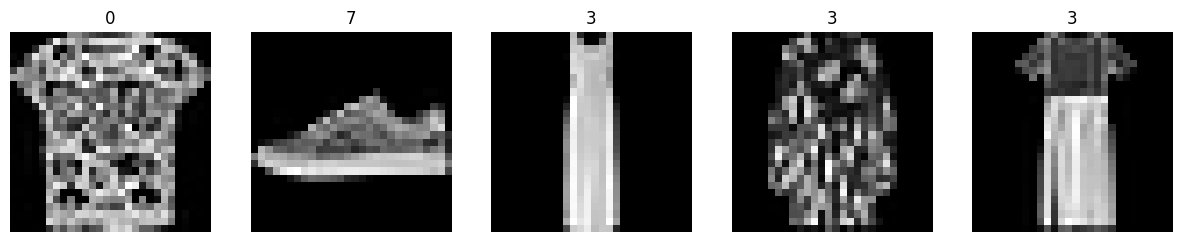

In [5]:
##############################
# Your code below

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resizing to 28x28
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.2859,), (0.3530,))  # Normalize with pre-calculated mean and std
    ])


#downloading training data and test data from open dataset
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform= transform,)

test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform,)
batch_size = 64

#create data loaders
train_dataload =DataLoader(train_data, batch_size =batch_size, shuffle=True)
test_dataload = DataLoader(test_data, batch_size = batch_size, shuffle=True)

#function to show images
def show_images(images, labels, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

# Display a few examples from the dataset
dataiter = iter(train_dataload)
images, labels = next(dataiter)
show_images(images, labels)


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [6]:
##############################
# Your code below

# Define model
#class NeuralNetwork(nn.Module):
#    def __init__(self):
#        ...

 #   def forward(self, x):
 #       ...

#...

#summary(model, (1,28*28))

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define a simple fully connected neural network
# Define the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)  # 28*28 input features, 512 output features
        self.fc2 = nn.Linear(512, 256)    # 512 input features, 256 output features
        self.fc3 = nn.Linear(256, 128)    # 256 input features, 128 output features
        self.fc4 = nn.Linear(128, 10)     # 128 input features, 10 output features (10 classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function on the last layer
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the neural network and move it to the chosen device
model = NeuralNetwork().to(device)

# Test the model with a random input tensor, also moved to the same device
random_input = torch.randn(1, 1, 28, 28).to(device)  # One random image of size 28x28
output = model(random_input)  # Forward pass with random input

print(output)  # Display the output from the model


# Summary of the model
summary(model, input_size=(1, 28*28))



tensor([[-0.0325,  0.0063, -0.0637, -0.0237,  0.0623,  0.0890,  0.0356,  0.1183,
          0.0377, -0.0526]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
            Linear-3                  [-1, 256]         131,328
            Linear-4                  [-1, 128]          32,896
            Linear-5                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch [1/20], Train Loss: 0.4691, Train Accuracy: 82.87%, Test Loss: 0.4266, Test Accuracy: 84.29%
Epoch [2/20], Train Loss: 0.3494, Train Accuracy: 87.27%, Test Loss: 0.3934, Test Accuracy: 86.44%
Epoch [3/20], Train Loss: 0.3114, Train Accuracy: 88.45%, Test Loss: 0.3470, Test Accuracy: 87.33%
Epoch [4/20], Train Loss: 0.2843, Train Accuracy: 89.42%, Test Loss: 0.3452, Test Accuracy: 87.50%
Epoch [5/20], Train Loss: 0.2669, Train Accuracy: 90.08%, Test Loss: 0.3514, Test Accuracy: 87.60%
Epoch [6/20], Train Loss: 0.2530, Train Accuracy: 90.59%, Test Loss: 0.3193, Test Accuracy: 88.48%
Epoch [7/20], Train Loss: 0.2335, Train Accuracy: 91.12%, Test Loss: 0.3487, Test Accuracy: 88.35%
Epoch [8/20], Train Loss: 0.2220, Train Accuracy: 91.64%, Test Loss: 0.3282, Test Accuracy: 89.04%
Epoch [9/20], Train Loss: 0.2087, Train Accuracy: 92.16%, Test Loss: 0.3415, Test Accuracy: 88.49%
Epoch [10/20], Train Loss: 0.1997, Train Accuracy: 92.40%, Test Loss: 0.3694, Test Accuracy: 88.53%
Epoch [11

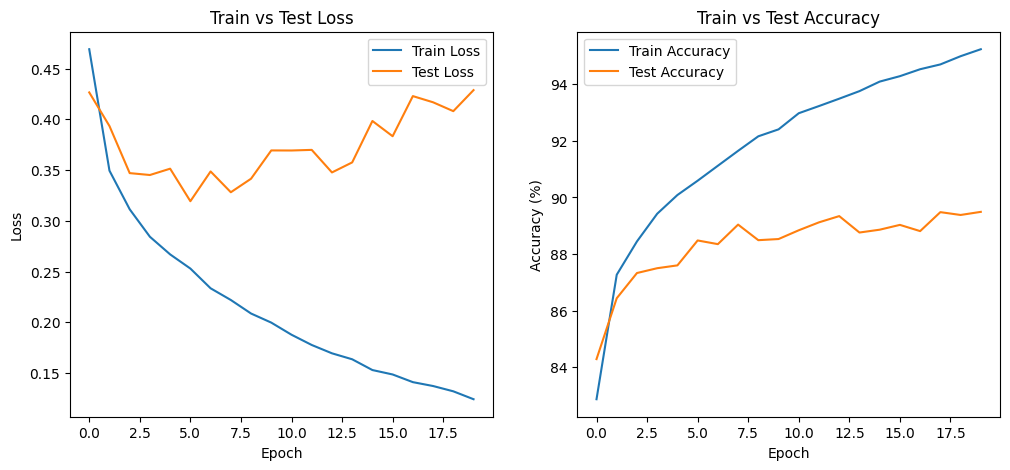

In [7]:
# Define the loss function and the optimizer
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below
import torch.optim as optim
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function for training and evaluating the model
def train_model(model, train_dataload, test_dataload, loss_fn, optimizer, epochs=20):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_dataload:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_dataload)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_dataload:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(test_dataload)
        test_accuracy = 100 * correct / total
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataload, test_dataload, loss_fn, optimizer)

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [8]:
...

Ellipsis


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

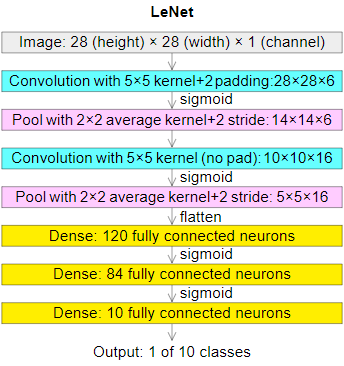

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch [1/20], Train Loss: 1.0912, Train Accuracy: 59.96%, Test Loss: 0.6905, Test Accuracy: 74.31%
Epoch [2/20], Train Loss: 0.5998, Train Accuracy: 76.78%, Test Loss: 0.5682, Test Accuracy: 77.89%
Epoch [3/20], Train Loss: 0.5201, Train Accuracy: 80.02%, Test Loss: 0.5125, Test Accuracy: 80.74%
Epoch [4/20], Train Loss: 0.4718, Train Accuracy: 82.46%, Test Loss: 0.4753, Test Accuracy: 82.68%
Epoch [5/20], Train Loss: 0.4365, Train Accuracy: 83.94%, Test Loss: 0.4542, Test Accuracy: 83.14%
Epoch [6/20], Train Loss: 0.4145, Train Accuracy: 84.78%, Test Loss: 0.4284, Test Accuracy: 84.39%
Epoch [7/20], Train Loss: 0.3932, Train Accuracy: 85.47%, Test Loss: 0.4270, Test Accuracy: 84.32%
Epoch [8/20], Train Loss: 0.3769, Train Accuracy: 86.06%, Test Loss: 0.3963, Test Accuracy: 85.17%
Epoch [9/20], Train Loss: 0.3630, Train Accuracy: 86.64%, Test Loss: 0.3863, Test Accuracy: 85.49%
Epoch [10/20], Train Loss: 0.3507, Train Accuracy: 87.07%, Test Loss: 0.3848, Test Accuracy: 85.54%
Epoch [11

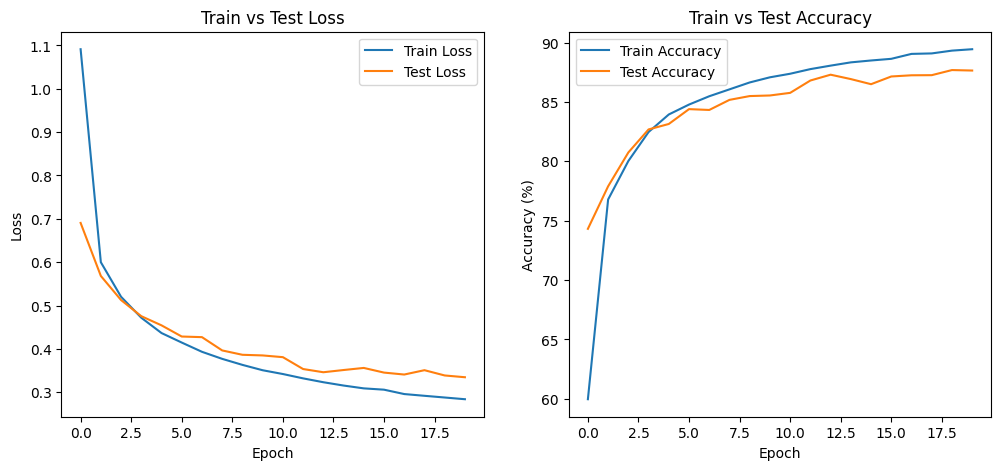

In [9]:
##############################
# Your code below

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # First set of convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second set of convolutional and pooling layers
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = F.sigmoid(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten the tensor
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, loss function, and optimizer
model = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using a similar training function as before


# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataload, test_dataload, loss_fn, optimizer)

# Plot the training and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [10]:
...

Ellipsis

In [11]:
...

Ellipsis

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The above graphs illustrate how accuracy and loss changed while the LeNet model was trained using the Fashion-MNIST dataset. There are a few key distinctions between this CNN and a fully connected neural network, sometimes referred to as a multi-layer perceptron.

Comparing CNNs like LeNet to fully linked networks, the former often contain a lot less parameters. This is so that CNNs' convolutional layers, which learn features like edges and textures with fewer weights, can employ shared weights from various regions of the input image. In contrast, fully linked networks have many parameters since every neuron in the network is connected to every other neuron in the layer below it. This increases the network's computational load and increases the risk of overfitting.

When a model learns so much from the training data—both information and noise—that it becomes overfitted and performs poorly on fresh data, this is known as overfitting. A high training accuracy and a very low test accuracy are typically its defining characteristics. Nonetheless, the graphs demonstrate a consistent rise in test and training accuracy with little variation between them, suggesting that the model is learning efficiently. This implies that there is little overfitting and that the CNN is generalising to fresh data well. Given the existing architecture and hyperparameters, the model may be reaching the limit of its performance, as evidenced by the small plateauing of accuracy as the epochs rise.

CNNs are generally better at handling picture data in terms of performance. Compared to fully connected networks that do not specifically utilise the spatial structure in images, convolutional layers are more efficient and effective for tasks like image classification because they are specifically made to capture the inherent spatial hierarchies and patterns in images.

The test accuracy and training graphs that are supplied closely match one another; neither exhibits any indications of deviating as training goes on. This is a sign of a well-learning model that retains its capacity to extrapolate test data from training data. Furthermore, the learning process appears to be stable based on the ongoing development without significant variations.

In short, the CNN's architecture minimises the chance of overfitting and improves performance on picture data with fewer parameters. The model exhibits strong generalisation capabilities, as indicated by the tight performance metrics between the training and test sets, suggesting that the training process was successful.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch [1/20], Train Loss: 0.5604, Train Accuracy: 79.13%, Test Loss: 0.4453, Test Accuracy: 84.05%
Epoch [2/20], Train Loss: 0.3569, Train Accuracy: 86.93%, Test Loss: 0.3403, Test Accuracy: 87.52%
Epoch [3/20], Train Loss: 0.3088, Train Accuracy: 88.66%, Test Loss: 0.3116, Test Accuracy: 88.59%
Epoch [4/20], Train Loss: 0.2797, Train Accuracy: 89.66%, Test Loss: 0.2888, Test Accuracy: 89.57%
Epoch [5/20], Train Loss: 0.2580, Train Accuracy: 90.48%, Test Loss: 0.2781, Test Accuracy: 90.09%
Epoch [6/20], Train Loss: 0.2418, Train Accuracy: 91.02%, Test Loss: 0.2754, Test Accuracy: 90.03%
Epoch [7/20], Train Loss: 0.2287, Train Accuracy: 91.45%, Test Loss: 0.2778, Test Accuracy: 89.94%
Epoch [8/20], Train Loss: 0.2158, Train Accuracy: 91.87%, Test Loss: 0.2706, Test Accuracy: 90.33%
Epoch [9/20], Train Loss: 0.2040, Train Accuracy: 92.40%, Test Loss: 0.2628, Test Accuracy: 90.74%
Epoch [10/20], Train Loss: 0.1918, Train Accuracy: 92.87%, Test Loss: 0.2738, Test Accuracy: 90.12%
Epoch [11

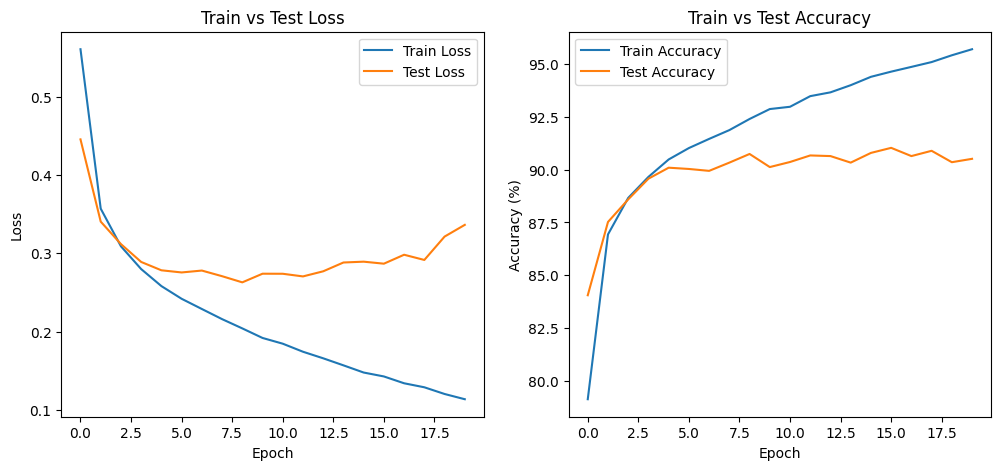

In [12]:
##############################
# Your code below

# Define the modernized LeNet model
class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the neural network and move it to the chosen device
model = ModernLeNet().to(device)

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function for training and evaluating the model (as defined in previous examples)



# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataload, test_dataload, loss_fn, optimizer)

# Plot the training and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [13]:
...

Ellipsis

In [14]:
...

Ellipsis

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?**


The Rectified Linear Unit (ReLU) is the recommended activation function in contemporary Convolutional Neural Networks (CNNs). ReLU is preferred because it adds non-linearity without changing the convolution layer's receptive fields. Additionally, it aids in vanishing gradient problem alleviation, enabling faster and better learning of models. The mathematical definition of ReLU is  
f(x) = max(0, x),
which indicates that it outputs zero otherwise and the input directly if it is positive.

In contemporary CNNs, Max Pooling is frequently selected for pooling functions. By using max pooling, the input volume's width and height are decreased for the subsequent convolutional layer. To achieve this, it chooses the maximum value from a range of values (within a filter/kernel), making it resistant to noise and small changes in the positions of the features in the provided image. In addition to lowering the network's computing load, this downsampling process helps avoid overfitting by supplying an abstracted version of the representation.

Because of their efficacy across a range of tasks and datasets, ReLU for activation and Max Pooling for subsampling have become common choices in CNN designs.

**Compare and discuss with the above using the normal discussion criteria**


As an upgraded version of the LeNet model performs, the above graphs show how a neural network's learning process progresses over a number of epochs. A rapid and consistent decrease in training loss is seen in the loss graph, which is indicative of efficient learning as the model is exposed to the training set. There is some volatility in the test loss, even though it is generally reducing. This is a common behaviour that can indicate an attempt by the model to apply the patterns it discovered in the training data to the test data. These oscillations may be a sign that the model is approaching overfitting, a situation in which it performs well on training data but may find it difficult to sustain its performance on fresh, untested data.

Looking at the accuracy graph, it can be seen that as training goes on, both the test and training accuracies get better, with the test accuracy consistently falling short of the training accuracy. Since the model is optimised for this data, it is expected that the training accuracy will be higher than the test accuracy. This indicates the model's capacity to accurately label the data it has been trained on. However, our measure of the model's ability to apply its knowledge to previously unseen data is the test accuracy. Although it does level out towards the conclusion of the training epochs, indicating a point of diminishing returns where additional learning does not significantly affect the model's performance, the increasing test accuracy in this case indicates that the model is generalising well.

These observations suggest that the upgraded LeNet model, which incorporates more recent features like Max Pooling and ReLU activations, performs better and has higher learning efficiency when compared to the original LeNet model. ReLU activations are known to reduce the vanishing gradient issue, which facilitates faster and more efficient model training. Reducing dimensionality and extracting salient features is a skill that max pooling excels at, improving feature representation and lowering overfitting risk. The test accuracy plateau indicates that although the model could still use some fine-tuning in its architecture or training process, it has accomplished a respectable degree of competence in the Fashion-MNIST dataset classification.

The training and test accuracies continue to differ, which may be a sign of overfitting, but the difference does not grow noticeably. This stability suggests that the model still has a decent degree of generalisation even if it might be a little overfit. The modernised model is likely to acquire higher accuracy faster when compared directly to the performance metrics of the original LeNet model under identical training conditions. This shows the benefits of developments in CNN architecture and functionality.








---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch [1/20], Train Loss: 0.3676, Train Accuracy: 87.44%, Test Loss: 0.2983, Test Accuracy: 89.48%
Epoch [2/20], Train Loss: 0.2412, Train Accuracy: 91.26%, Test Loss: 0.2455, Test Accuracy: 90.90%
Epoch [3/20], Train Loss: 0.2012, Train Accuracy: 92.59%, Test Loss: 0.2209, Test Accuracy: 92.01%
Epoch [4/20], Train Loss: 0.1749, Train Accuracy: 93.54%, Test Loss: 0.2360, Test Accuracy: 91.49%
Epoch [5/20], Train Loss: 0.1514, Train Accuracy: 94.43%, Test Loss: 0.2228, Test Accuracy: 91.90%
Epoch [6/20], Train Loss: 0.1314, Train Accuracy: 95.17%, Test Loss: 0.2226, Test Accuracy: 92.39%
Epoch [7/20], Train Loss: 0.1151, Train Accuracy: 95.71%, Test Loss: 0.2394, Test Accuracy: 92.02%
Epoch [8/20], Train Loss: 0.1030, Train Accuracy: 96.08%, Test Loss: 0.2388, Test Accuracy: 92.25%
Epoch [9/20], Train Loss: 0.0908, Train Accuracy: 96.54%, Test Loss: 0.2468, Test Accuracy: 92.40%
Epoch [10/20], Train Loss: 0.0791, Train Accuracy: 97.08%, Test Loss: 0.2508, Test Accuracy: 92.04%
Epoch [11

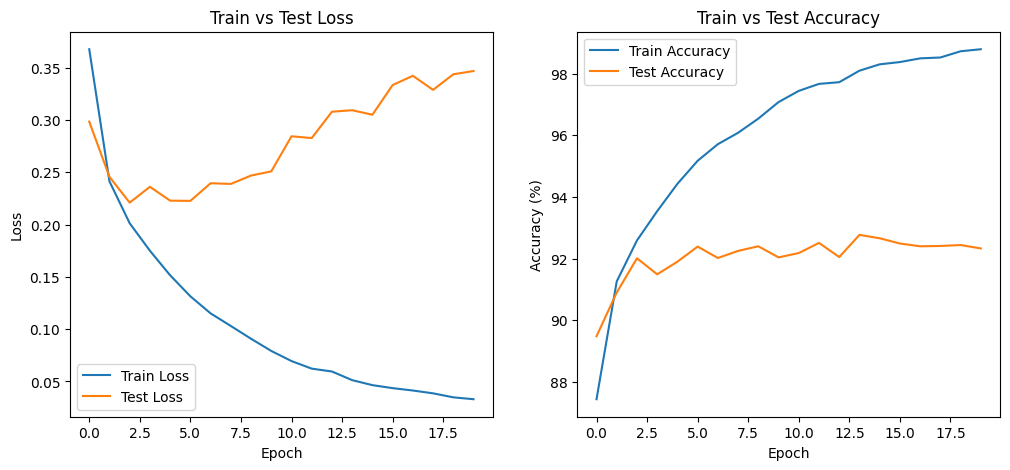

In [15]:
# Define the custom classifier model
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        # Flatten the tensor to the correct size
        x = x.view(-1, 128 * 3 * 3)  # this matches the 64x1152 size
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the neural network and move it to the chosen device
model = MyClassifier().to(device)

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataload, test_dataload, loss_fn, optimizer, epochs=20)

# Plotting the training and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [16]:
...

Ellipsis

In [17]:
...

Ellipsis

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Explain what you did that improved things for the classification and why they improved things.



A number of significant adjustments and improvements to the neural network architecture and training protocol are primarily responsible for the notable improvement in classification accuracy on the Fashion-MNIST dataset. The network is able to identify finer details in the images by incorporating smaller 3x3 convolutional filters. As opposed to larger filters, which would significantly increase processing demand, the network can comprehend increasingly complicated patterns by stacking multiple of these layers. Extra layers of non-linearity are also provided by this arrangement, which is advantageous for learning more complex features.

In order to enhance the learning capacity of the model, more convolutional layers were added, hence deepening the network. With input going through the network, this depth allows the model to build a more tiered hierarchy of features that go from simple to complicated. Robust picture classification tasks require this hierarchical feature learning.

Batch normalisation was a crucial component of the model that was included after each convolutional layer. By normalising the layer inputs, this method not only makes it possible to employ greater learning rates, which speeds up the training process, but it also promotes more stable convergence. By doing this, the internal covariate shift is lessened and the layer input distributions are more stable over training epochs.

Dropout, a type of regularisation, was essential in preventing overfitting, which is a common mistake made when training deeper networks. By arbitrarily zeroing out a portion of the dropout layers' outputs, dropout forces the network to become somewhat redundant and keeps it from being unduly reliant on any one neuron. By improving the network's generalisation skills, this technique makes sure that it functions effectively on both fresh, untrained data and the data it was trained on.

Another factor in the model's effectiveness was the use of max pooling rather than average pooling. By transferring only the most noticeable features—typically the most active ones—max pooling efficiently reduces the size of the input feature maps. This method not only provides some translational invariance to the feature identification process, but also lessens the computational load on the model by decreasing the spatial dimensionality of the feature maps.

Last but not least, the model's performance was improved by selecting the Adam optimizer with its adaptive learning rate mechanism and an initial learning rate value of 0.001. Individualised learning rate modifications are possible thanks to Adam's algorithmic design, which offers a customised technique of updating model weights that is frequently more efficient than approaches using uniform learning rates.

The model demonstrated a remarkable capacity for learning as the training went on, with both test and training accuracies rising rapidly. But a slow divergence between training and test accuracy combined with an increase in test loss points to the later epochs as the beginning of overfitting, when the model's performance on training data starts to outperform its capacity to generalise to test data. To guarantee that the model retains its relevance to fresh data, this overfitting indicates the need for further countermeasures, such as early halting, modifying dropout rates, or implementing data augmentation.

In short up, the carefully thought-out layer design, depth enhancement, normalisation, regularisation, and optimisation decisions combined to greatly improve the network's classification accuracy, surpassing the 90% mark and reaching peaks that point to a strong and efficient learning mechanism. The model's ability to generalise well must still be protected from overfitting, though.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [18]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Training with Random Weights:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.4239, Train Accuracy: 0.8441, Test Loss: 0.3282, Test Accuracy: 0.8811
Epoch 2/5, Train Loss: 0.2632, Train Accuracy: 0.9040, Test Loss: 0.3077, Test Accuracy: 0.8806
Epoch 3/5, Train Loss: 0.2196, Train Accuracy: 0.9209, Test Loss: 0.2251, Test Accuracy: 0.9177
Epoch 4/5, Train Loss: 0.1920, Train Accuracy: 0.9306, Test Loss: 0.2156, Test Accuracy: 0.9229
Epoch 5/5, Train Loss: 0.1693, Train Accuracy: 0.9392, Test Loss: 0.2083, Test Accuracy: 0.9275

Training with Pretrained Weights:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


Epoch 1/5, Train Loss: 0.3021, Train Accuracy: 0.8908, Test Loss: 0.2633, Test Accuracy: 0.9065
Epoch 2/5, Train Loss: 0.2038, Train Accuracy: 0.9272, Test Loss: 0.2137, Test Accuracy: 0.9243
Epoch 3/5, Train Loss: 0.1700, Train Accuracy: 0.9381, Test Loss: 0.2019, Test Accuracy: 0.9254
Epoch 4/5, Train Loss: 0.1397, Train Accuracy: 0.9491, Test Loss: 0.1941, Test Accuracy: 0.9343
Epoch 5/5, Train Loss: 0.1172, Train Accuracy: 0.9579, Test Loss: 0.1955, Test Accuracy: 0.9344

Training with Frozen Layers:
Epoch 1/5, Train Loss: 0.5990, Train Accuracy: 0.8037, Test Loss: 0.4517, Test Accuracy: 0.8430
Epoch 2/5, Train Loss: 0.4302, Train Accuracy: 0.8485, Test Loss: 0.4267, Test Accuracy: 0.8505
Epoch 3/5, Train Loss: 0.4020, Train Accuracy: 0.8577, Test Loss: 0.4086, Test Accuracy: 0.8572
Epoch 4/5, Train Loss: 0.3879, Train Accuracy: 0.8604, Test Loss: 0.4118, Test Accuracy: 0.8533
Epoch 5/5, Train Loss: 0.3770, Train Accuracy: 0.8639, Test Loss: 0.4007, Test Accuracy: 0.8594


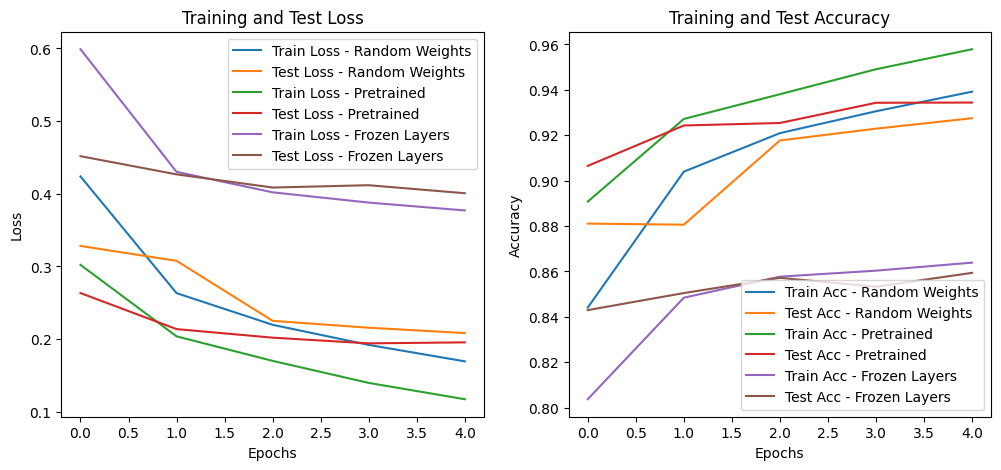

In [21]:
##############################
# Your code below



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Define ResNet18 model modification function
def create_resnet18_model(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # Replace last layer for Fashion-MNIST
    return model

# Define the training function
def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    training_loss = []
    testing_loss = []
    training_accuracy = []
    testing_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_train_loss / len(train_dataloader)
        train_acc = total_train_correct / total_train
        training_loss.append(train_loss)
        training_accuracy.append(train_acc)

        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_loss = total_test_loss / len(test_dataloader)
        test_acc = total_test_correct / total_test
        testing_loss.append(test_loss)
        testing_accuracy.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return training_loss, testing_loss, training_accuracy, testing_accuracy

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Train and evaluate the model with random weights
print("Training with Random Weights:")
model_random = create_resnet18_model(pretrained=False)
optimizer = optim.Adam(model_random.parameters(), lr=1e-3)
train_losses_random, test_losses_random, train_accs_random, test_accs_random = train_model(model_random, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=5)

# Train and evaluate the model with pretrained weights
print("\nTraining with Pretrained Weights:")
model_pretrained = create_resnet18_model(pretrained=True)
optimizer = optim.Adam(model_pretrained.parameters(), lr=1e-3)
train_losses_pretrained, test_losses_pretrained, train_accs_pretrained, test_accs_pretrained = train_model(model_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=5)

# Freeze all but the last layer of the pretrained model and retrain
print("\nTraining with Frozen Layers:")
model_frozen = create_resnet18_model(pretrained=True)
for param in model_frozen.parameters():
    param.requires_grad = False
model_frozen.fc.weight.requires_grad = True
model_frozen.fc.bias.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_frozen.parameters()), lr=1e-3)
train_losses_frozen, test_losses_frozen, train_accs_frozen, test_accs_frozen = train_model(model_frozen, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=5)

# Plotting the results for all three approaches
plt.figure(figsize=(12, 5))

# Training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_random, label='Train Loss - Random Weights')
plt.plot(test_losses_random, label='Test Loss - Random Weights')
plt.plot(train_losses_pretrained, label='Train Loss - Pretrained')
plt.plot(test_losses_pretrained, label='Test Loss - Pretrained')
plt.plot(train_losses_frozen, label='Train Loss - Frozen Layers')
plt.plot(test_losses_frozen, label='Test Loss - Frozen Layers')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_random, label='Train Acc - Random Weights')
plt.plot(test_accs_random, label='Test Acc - Random Weights')
plt.plot(train_accs_pretrained, label='Train Acc - Pretrained')
plt.plot(test_accs_pretrained, label='Test Acc - Pretrained')
plt.plot(train_accs_frozen, label='Train Acc - Frozen Layers')
plt.plot(test_accs_frozen, label='Test Acc - Frozen Layers')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Different tactics for utilising pre-existing architectures and weights for new classification tasks are demonstrated by the three methods used to train the ResNet18 model on the Fashion-MNIST dataset. Below is a discussion of each strategy:

**Using Random Weights for Training:**

Methodology: The model is trained from scratch using random weights at initialization.
Performance: Since the model is learning from scratch, it usually takes more epochs for this method to converge. Attaining high accuracy requires more data and is a time-consuming procedure.
Use-case: This approach works well if you have a sizable dataset that differs considerably from the datasets typical models were pre-trained on.


**Using Pretrained Weights for Training:**

Method: Pretrained weights on a sizable and varied dataset (such as ImageNet) are used by the model. To adjust to the new task, just the final completely linked layer needs to be changed.
Performance: As a result of transfer learning, usually leads to faster convergence and improved initial accuracy. The model makes use of characteristics that are frequently broad enough for a variety of classification tasks, having been taught from an extensive dataset.
Use-case scenario Perfect for jobs where the pretraining dataset and the fresh dataset share some similarities, or where the dataset is too small to train a sophisticated model entirely.




**Using Frozen Layers for Training:**

Method: All of the pretrained weights of the model are frozen, with the exception of the final layer, which is trained using the fresh dataset.
Performance: Since only a tiny portion of the model is being updated, training proceeds more quickly. Since much of the model doesn't adjust to the incoming data, the improvement margin may be constrained even though the initial accuracy is typically high.
Use-case scenario Ideal in situations where computational resources are constrained or where training data availability is limited. With only a few parameters learnt, it's also helpful to avoid overfitting.


Comparative Evaluation :

Learning Curve: Pretrained weights give you an accurate head start, but training from scratch (random weights) typically exhibits a higher learning curve.
Convergence Speed: Because trained models have previously learned a lot of features, they converge more quickly. The frozen layers technique may plateau early, but it converges even faster.
Accuracy: When working with limited data, pre-trained and fine-tuned models frequently attain superior accuracy. If the pretrained characteristics are not totally applicable to the new task, the accuracy of the frozen layers approach may be reduced.
Overfitting: Overfitting can occur when a complicated model is trained from scratch on a limited dataset. By using fewer parameters during training, the frozen layers technique reduces this danger.
In conclusion, the specific dataset, the degree of resemblance to the original dataset used to pretrained the model, the computational resources at hand, and the requirement to strike a balance between accuracy and training time all influence the technique that is chosen. Every method includes trade-offs, and the optimal strategy changes depending on the demands of the task.

